<a href="https://colab.research.google.com/github/bahrad/PTAB/blob/master/PTAB_xgboost_github.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Initialization

In [ ]:
%tensorflow_version 2.x

%xmode Context
# Verbose

import tensorflow as tf
from tensorflow import keras
import numpy as np
!pip install xlrd==2.0.1
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import os
import itertools

from collections import Counter, defaultdict
import random
from pandas import DataFrame
import datetime
from datetime import datetime
import dateutil
from dateutil.parser import parse as dateparse
from tqdm.notebook import tqdm
import time

import sklearn as sk
from sklearn.preprocessing import MultiLabelBinarizer, QuantileTransformer, OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.model_selection import KFold, StratifiedShuffleSplit, ShuffleSplit
from sklearn.linear_model import LogisticRegression
import sklearn.metrics
from sklearn.metrics import accuracy_score,classification_report, make_scorer, balanced_accuracy_score, f1_score, coverage_error, roc_auc_score, confusion_matrix, plot_confusion_matrix
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.utils import resample, shuffle
from sklearn.base import BaseEstimator, ClassifierMixin, TransformerMixin
from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import TSNE
from sklearn.utils import class_weight

from sklearn.feature_extraction.text import TfidfVectorizer
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

from imblearn.over_sampling import SMOTE, RandomOverSampler, ADASYN, BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler, EditedNearestNeighbours, CondensedNearestNeighbour, AllKNN
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.pipeline import make_pipeline,Pipeline

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import string
import re
import ast
# import unicodedata

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('punkt')

!pip install lime
import lime
from lime import lime_text
from lime.lime_text import LimeTextExplainer
from lime.explanation import Explanation

!pip install shap
import shap

In [ ]:
# COMMENT OUT FOR PUBLIC CODE
from google.colab import drive, files
# drive.mount('/content/drive')

FILELOC = "DATA/"

#Pre-Processing

In [ ]:
ptab = pd.read_csv(FILELOC + 'PTAB_Institution_Proceedings_to_20211231.tsv', sep='\t')
print(len(ptab))
ptab.drop_duplicates('Proceeding', inplace=True)
print(len(ptab))
ptab['date'] = ptab['Case Filing Date'].apply(dateparse)

In [ ]:
with open(FILELOC + 'IPR_Proceeding_PartyNames_12312022.txt', 'r', encoding="ISO-8859-1") as f:
    outfile = [line.rstrip('\n') for line in f]
case = []; number = []
for k in range(0,len(outfile),2):
    case.append(outfile[k])
    number.append(outfile[k+1])
casedf = pd.DataFrame.from_dict({'case':case, 'proc':number})
casedf.drop_duplicates('proc', inplace=True)
casedf['proc'] = casedf['proc'].apply(lambda x: x.split('(')[0].strip())
casedf['name'] = casedf['case'].apply(lambda x: x.strip("\""))
casedf[casedf.name.str.contains('Petition')].to_csv('a.csv')

common_names = set(['business', 'doing', 'company', 'corporation', 'formerly', 'et', 'al'])

def f(x):
    y = x
    if 'Petition' in x:
        if 'Covered' in x:
            y = x.replace("Petition for Covered Business Method Patent Review by","")
        elif 'Inter' in x:
            y = x.replace("Petition for Inter Partes Review by", "")
    y = y.translate(str.maketrans('', '', string.punctuation))
    if 'v' in y:
        y = y.replace("v", "")
    y = [s.strip() for s in y.strip().split(' ') if s != "" and s not in STOPWORDS|common_names]
    return y
casedf['party_names'] = casedf['name'].apply(f)

ptdf = pd.merge(ptab,casedf,left_on='Proceeding',right_on='proc',how='inner')
print(len(ptab), len(casedf), len(ptdf))

In [ ]:
# DOCTYPE = 'Responses'
DOCTYPE = 'Decisions'
# DOCTYPE = 'Petitions'

ptdf.drop(columns=list({'Petitions','Responses','Decisions'}-{DOCTYPE}), inplace=True)
ptdf.drop(columns=['case','proc'], inplace=True)

In [ ]:
# Drop error messages and duplicates

ptdf[DOCTYPE] = ptdf[DOCTYPE].fillna('NA')

# clean up texts by removing (cid:##) which is likely an artifact of the PDF reading process
cid_str = re.compile("\(cid:\d+\)")
def f(x):
    return re.sub(cid_str, "", x)
ptdf[DOCTYPE] = ptdf[DOCTYPE].apply(f)

def get_word_count(text):
    return len(text.split())
ptdf[f'{DOCTYPE}_Len'] = ptdf[DOCTYPE].apply(get_word_count)
MIN_LENGTH = 50

print(len(ptdf))
ptdf.drop(ptdf[ptdf[f'{DOCTYPE}_Len'] < MIN_LENGTH].index, inplace=True)
print(len(ptdf))
ptdf.drop_duplicates(DOCTYPE, keep=False, inplace=True)
print(len(ptdf))

ptdf.reset_index(inplace=True)

10462
9296
9079


##Outcome Statistics

In [ ]:
Years = [2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021]
granted = np.array([len(ptdf[(ptdf.Decision=='Granted') & (ptdf.date.dt.year==yr)]) for yr in Years])
denied = np.array([len(ptdf[(ptdf.Decision=='Denied') & (ptdf.date.dt.year==yr)]) for yr in Years])
mixed = np.array([len(ptdf[(ptdf.Decision=='Mixed') & (ptdf.date.dt.year==yr)]) for yr in Years])
print(granted, denied, mixed)

[ 39 212 439 442 468 553 708 542 612 237] [ 11 153 395 420 430 481 461 381 389 183] [ 50 281 401 290 225 181   1   0   0   0]


In [ ]:
granted/(denied+granted+mixed)

array([0.39      , 0.32817337, 0.35546559, 0.38368056, 0.41674087,
       0.45514403, 0.60512821, 0.5872156 , 0.61138861, 0.56428571])

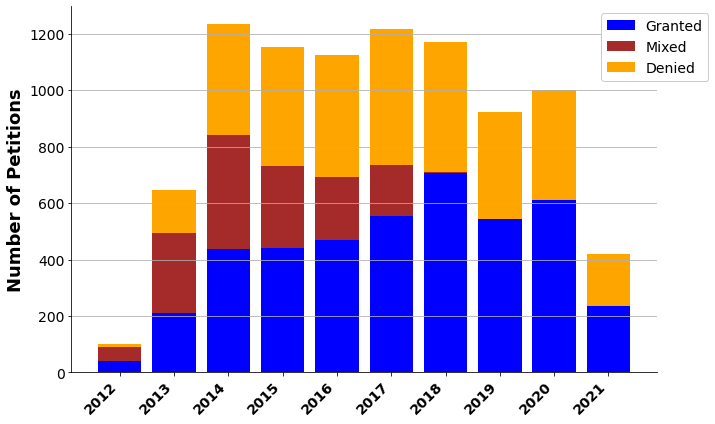

In [ ]:
nbars = len(Years)
x_pos = np.linspace(0,nbars-1,nbars)
width = 0.5

fig, ax = plt.subplots()
fig.set_size_inches(10,6)

ax.bar(x_pos, granted, label='Granted', color='blue')
ax.bar(x_pos, mixed, bottom=granted, label='Mixed', color='brown')
ax.bar(x_pos, denied, bottom=granted+mixed, label='Denied', color='orange')

ax.set_xticks(x_pos)
ax.set_xticklabels(Years, rotation=45, ha='right', fontsize=14, fontweight='bold')
# ax.set_ylim([0.4,1.0])
plt.yticks(fontsize=14)
ax.set_ylabel('Number of Petitions', fontsize=18, fontweight='bold')
ax.yaxis.grid(True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(framealpha=1.0, fontsize=14, loc='upper right', bbox_to_anchor=(1.1, 1))
plt.tight_layout()
plt.show()

##Tokenize

In [ ]:
Params = {}

In [ ]:
Params['remove_stop_words'] = True
Params['remove_alphanumeric'] = True
Params['remove_punctuation'] = True
Params['remove_shortword_size'] = 3
Params['remove_propernouns'] = True
Params['keep_case_names'] = False

Params['clean_all'] = True
Params['remove_shortword_size'] = 3

Params['use_lowercase'] = True

In [ ]:
if Params['remove_propernouns'] or Params['clean_all']:
    def f(x):
        if 'v.' not in x:
            return 'NO_PARTY'
        else:
            y = x.split('v.')
            petitioner = y[0].split()[0].strip().replace(',', '')
            patentowner = y[1].split()[0].strip().replace(',', '')
            return [petitioner, patentowner]

parties_first = casedf['name'].apply(f).values
CASENAMES = set(itertools.chain.from_iterable(parties_first))

In [ ]:
docs = ptdf[DOCTYPE].values
partyname_list = ptdf['party_names'].tolist()

In [ ]:
if Params['clean_all']:
    remove_shortword_size = Params['remove_shortword_size']
    def process_docs(x):
        doc = x
        t = nltk.tokenize.word_tokenize(doc)
        PUNCT = string.punctuation + u"‘’´“”–-"
        propernouns = set([a for a,b in nltk.tag.pos_tag(t) if b=='NNP'])
        shortwords = set([tt for tt in t if len(tt) <= remove_shortword_size])
        reject_list = set(PUNCT)|propernouns|STOPWORDS|shortwords

        proct = [tt for tt in t if tt.isalpha() and tt not in reject_list]
        return proct

else:
    remove_punct = Params['remove_punctuation']
    remove_stopwords = Params['remove_stop_words']
    remove_alphanumeric = Params['remove_alphanumeric']
    # set to False or None if not used otherwise remove this length or less
    remove_shortword_size = Params['remove_shortword_size']
    remove_proper = Params['remove_propernouns']

    def process_docs(x):
        doc, partynames = x
        t = nltk.tokenize.word_tokenize(doc)
        PUNCT = string.punctuation + u"‘’´“”–-"
        if remove_punct:
            proct = [tt for tt in t if tt not in set(PUNCT)]
        if remove_stopwords:
            proct = [tt for tt in proct if tt not in STOPWORDS]
        if remove_alphanumeric:
            proct = [tt for tt in proct if tt.isalpha()]
        if remove_shortword_size:
            proct = [tt for tt in proct if len(tt) > remove_shortword_size]
        propernouns = set([a for a,b in nltk.tag.pos_tag(proct) if b=='NNP'])
        if Params['keep_case_names']:
            propernouns = propernouns - (CASENAMES - set(partynames))
        if remove_proper:
            proct = [tt for tt in proct if tt not in propernouns]
        return proct

if Params['clean_all']:
    tokdocs = ptdf[DOCTYPE].apply(process_docs)
else:
    tokdocs = [process_docs([docs[ind], partyname_list[ind]]) for ind in tqdm(ptdf.index)]

##Missing words in pre-trained embeddings

In [ ]:
with open(FILELOC + 'Tokenized_Responses_noproper_20220131.pkl', 'rb') as f:
    _, t1 = pickle.load(f)
with open(FILELOC + 'Tokenized_Decisions_noproper_20220131.pkl', 'rb') as f:
    _, t2 = pickle.load(f)
with open(FILELOC + 'Tokenized_Petitions_noproper_20220131.pkl', 'rb') as f:
    _, t3 = pickle.load(f)

t1 = [t for t in t1]
t2 = [t for t in t2]
t3 = [t for t in t3]

tokdocs = t1 + t2 + t3

In [ ]:
wordcount = Counter(itertools.chain.from_iterable([[t.lower() for t in doc] for doc in tokdocs]))
vocabsize = len(wordcount)

In [ ]:
embedding_dim = 200
PRETRAINED_EMBEDDINGS_FILE = FILELOC + f"glove.6B.{embedding_dim}d.txt"
# embedding_dim = 200
# PRETRAINED_EMBEDDINGS_FILE = FILELOC + f"Law2Vec.{embedding_dim}d.txt"

embedindex = {}
with open(PRETRAINED_EMBEDDINGS_FILE) as f:
    for line in tqdm(f):
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embedindex[word] = coefs

print("Found %s word vectors." % len(embedindex))

0it [00:00, ?it/s]

Found 400000 word vectors.


In [ ]:
hits = 0; misses = 0
# Prepare embedding matrix
for word in wordcount.keys():
    embedding_vector = embedindex.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 40479 words (119248 misses)


In [ ]:
missingwords = list(set(wordcount.keys()) - set(embedindex.keys()))
df = pd.DataFrame.from_dict({'words':[m for m in missingwords],'count':[wordcount[m] for m in missingwords]})

In [ ]:
# Converted 24723 words (27096 misses)
law2vec_missing_df = df.copy()
law2vec_missing_df.sort_values(by='count', ascending=False).head(50)

In [ ]:
# Converted 29951 words (21868 misses)
glove_missing_df = df.copy()
glove_missing_df.sort_values(by='count', ascending=False).head(50)

9079
8985


#XGBoost

##Data Preparation

In [ ]:
# take a list of tokenized documents (i.e. list of lists) and derive an integer
# mapping dictionary (0 = not used, 1 = out of vocabular, 2+ are tokens) for the
# all (if num_words=None) or num_words most common words
# It will generate a 2D array of truncated / padded document vectors (vec_len)
# If lowercase set to True then converts all tokens to lowercase
# Out of vocabulary string is "oov_str" (default '<OOV>')

class Token2Int(BaseEstimator,TransformerMixin):
    def __init__(self, vec_len, num_words=None, oov_str='<OOV>', lowercase=True):
        self.vec_len = vec_len
        self.num_words = num_words
        self.oov_str = oov_str
        self.lowercase = lowercase

    def fit(self, X, y=None):
        if type(X[0]) is not list:
            X = [X] # only a single document was passed
        if self.lowercase:
            X = [[d.lower() for d in doc] for doc in X]
        wc = Counter(itertools.chain.from_iterable(X))
        self.word_count = wc
        vocab = [w for w,c in wc.most_common(self.num_words)]
        vocab.insert(0, self.oov_str)       # assign 1 to OOV
        self.vocab = vocab
        self.vocab_size = len(vocab)
        wordmap = {n:m+1 for m,n in enumerate(vocab)}
        self.word_index = wordmap
        self.index_word = {n:m for m,n in wordmap.items()}
        return self

    def transform(self, X):
        if type(X[0]) is not list:
            X = [X] # only a single document was passed
        # X = np.array(list(itertools.zip_longest(*X, fillvalue=0))).T
        if self.lowercase:
            # X = np.vectorize(str.lower)(X)
            X = [[d.lower() for d in doc] for doc in X]
        wordmap = self.word_index
        vocab = self.vocab
        veclen = self.vec_len
        numdocs = len(X)
        # wordmap['0'] = 0
        # # textpad = np.array([t[:veclen] if len(t) >= veclen else t + ['0']*(veclen-len(t)) for t in X]).astype(str)
        # X = [[wordmap.get(x, 1) for x in t] for t in X]
        # return pad_sequences(X, maxlen=veclen, padding='post', truncating='post')
        textpad = np.zeros((numdocs, veclen))
        for d in tqdm(range(numdocs)):
            doc = X[d]
            doclen = min(len(doc), veclen)
            textpad[d,:doclen] = [wordmap.get(word, 1) for word in doc[:doclen]]
            # textpad[d,:doclen] = [wordmap[word] if word in vocab else 1 for word in doc[:doclen]]
        return textpad

    def reverse(self, textpad):
        texts = []
        for row in textpad:
            int2text = ['' if w==0 else self.index_word[w] for w in row]
            texts.append(' '.join(int2text).strip())
        return texts

In [ ]:
with open(FILELOC + 'Tokenized_Responses_noproper_20220131.pkl', 'rb') as f:
    ptdf, tokdocs = pickle.load(f)

# with open(FILELOC + 'Tokenized_Decisions_noproper_20220131.pkl', 'rb') as f:
#     ptdf, tokdocs = pickle.load(f)

# with open(FILELOC + 'Tokenized_Petitions_noproper_20220131.pkl', 'rb') as f:
#     ptdf, tokdocs = pickle.load(f)

# with open(FILELOC + 'Tokenized_Responses_20220212.pkl', 'rb') as f:
#     ptdf, tokdocs = pickle.load(f)

In [ ]:
map_outcome2unpat = {'Denied': 0,
                     'Denied on Rehearing': -1,
                    #  'Mixed': 0,
                     'Mixed': -1,
                     'Granted': 1,
                     'Granted on Rehearing': -1,
                     'Indefinite': -1,
                     }
ptdf['Unpatentable'] = ptdf['Decision'].map(map_outcome2unpat)

selind = ptdf[ptdf['Unpatentable'] != -1].index

print(len(ptdf))
ptdf.drop(ptdf[ptdf['Unpatentable'] == -1].index, inplace=True)
print(len(ptdf))
ptdf.reset_index(inplace=True)
tokdocs = [tokdocs[ind] for ind in range(len(tokdocs)) if ind in selind]

9283
7843


In [ ]:
# trainindex = ptdf[ptdf.date.between(pd.Timestamp(2018,7,1), pd.Timestamp(2020,11,30))].index
# testindex = ptdf[ptdf.date.between(pd.Timestamp(2020,12,1),pd.Timestamp(2021,3,31))].index

trainindex = ptdf[ptdf.date < pd.Timestamp(2017,12,31)].index
testindex = ptdf[ptdf.date > pd.Timestamp(2019,1,1)].index

print(len(trainindex), len(testindex))

In [ ]:
ytrain = ptdf.loc[trainindex, 'Unpatentable'].values
ytest = ptdf.loc[testindex, 'Unpatentable'].values

In [ ]:
Params = {}
Params['num_words_to_use'] = 20000
Params['text_length'] = 8000

trainindex = ptdf[ptdf.date.between(pd.Timestamp(2018,7,1), pd.Timestamp(2020,11,30))].index
testindex = ptdf[ptdf.date >= pd.Timestamp(2020,12,1)].index

ytrain = ptdf.loc[trainindex, 'Unpatentable'].values
ytest = ptdf.loc[testindex, 'Unpatentable'].values

tdocs = [t if len(t) < Params['text_length'] else t[:Params['text_length']] for t in tokdocs]
tdocs = [[t.lower() for t in doc] for doc in tdocs]

toktrain = [tdocs[ind] for ind in range(len(tdocs)) if ind in trainindex]
toktest = [tdocs[ind] for ind in range(len(tdocs)) if ind in testindex]

In [ ]:
# Params = {}
# Params['num_words_to_use'] = None
# Params['text_length'] = 4000

# trainindex = ptdf[ptdf.date.between(pd.Timestamp(2018,7,1), pd.Timestamp(2020,11,30))].index
# testindex = ptdf[ptdf.date >= pd.Timestamp(2020,12,1)].index

# ytrain = ptdf.loc[trainindex, 'Unpatentable'].values
# ytest = ptdf.loc[testindex, 'Unpatentable'].values

# tdocs = [t if len(t) < Params['text_length'] else t[:Params['text_length']] for t in tokdocs]
# tdocs = [[t.lower() for t in doc] for doc in tdocs]

# toktrain = [tdocs[ind] for ind in range(len(tdocs)) if ind in trainindex]
# toktest = [tdocs[ind] for ind in range(len(tdocs)) if ind in testindex]

##Model Fitting

In [ ]:
def set_model(random_state=2856):
    return xgb.XGBClassifier(
        objective= "binary:logistic",

        booster='dart',  # rate_drop, skip_drop', and 'sample_type' are for dart booster
        rate_drop= 0.1, # 0.1,
        skip_drop= 0.5, # 0.5,
        sample_type='weighted',

        random_state=random_state,
        subsample=0.8,          # typically 0.5-1, lower values = more conservative
        reg_lambda=2.0,         # L2 regularization, default 1 (reg_alpha default 0 is L1)
        max_depth=15,           # 8
        learning_rate=0.1,   # 0.001
        gamma=0,                # makes model more conservative
        colsample_bytree=0.8,   # typically 0.5-1, fraction of columns to be randomly sampled / tree
        n_jobs=-1,
        eval_metric = 'auc',
        # predictor = "cpu_predictor",
        predictor = "gpu_predictor",
        n_estimators = 1200,
        )

In [ ]:
def dummy_fun(doc):
    return doc
def return_tfidf(max_features, vocabulary=None):
    tfidf = TfidfVectorizer(analyzer='word', tokenizer=dummy_fun, preprocessor=dummy_fun,
                            token_pattern=None, max_features=max_features, vocabulary=vocabulary)  
    return tfidf

In [ ]:
vectorizer = return_tfidf(max_features=Params['num_words_to_use'])

vectorizer.fit(toktrain)
xtrain = vectorizer.transform(toktrain)
xtest = vectorizer.transform(toktest)

In [ ]:
class_weights = list(class_weight.compute_class_weight(class_weight='balanced',
                                                    classes=np.unique(ytrain), y=ytrain))
sample_weights = np.array([class_weights[y] for y in ytrain])
print(class_weights)

[1.0693121693121692, 0.9391263940520446]


###Responses - Outcomes

In [ ]:
vectorizer = return_tfidf(max_features=Params['num_words_to_use'])
vectorizer.fit(toktrain)
xtrain = vectorizer.transform(toktrain)
xtest = vectorizer.transform(toktest)

class_weights = list(class_weight.compute_class_weight(class_weight='balanced',
                                                    classes=np.unique(ytrain), y=ytrain))
sample_weights = np.array([class_weights[y] for y in ytrain])
print(class_weights)

In [ ]:
RANDSTATE_LIST = [10666, 559, 1024, 6, 39842]
results_test = {}; results_val = {}; results_paper = {}
results_cleantest = {}; results_cleanval = {}; results_cleanpaper = {}

for RANDSTATE in RANDSTATE_LIST:
    print("training...")
    model_tfidf = set_model(RANDSTATE)
    model_tfidf.fit(xtrain, ytrain,
                    sample_weight=sample_weights,
                    verbose=False,
                    )
    pred_train = model_tfidf.predict(xtrain)
    pred_test = model_tfidf.predict(xtest)

    print(confusion_matrix(ytest,np.round(pred_test)))

In [ ]:
model_tfidf_booster = model_tfidf.get_booster()

feature_names = vectorizer.get_feature_names_out()

fs_dict = model_tfidf_booster.get_fscore()
fsdf = pd.DataFrame.from_dict({'feature':fs_dict.keys(),
                               'score':fs_dict.values()}).sort_values(by='score', ascending=False)
def f(x):
    feature_id = int(x[1:])
    return feature_names[feature_id]

fsdf['feature_name'] = fsdf.feature.apply(f)

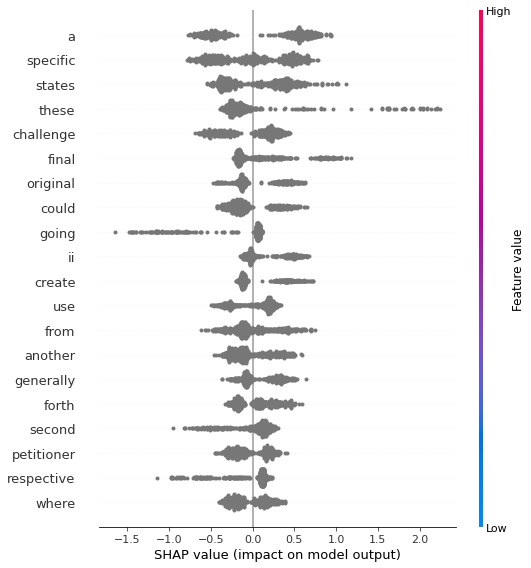

In [ ]:
shap_pred_raw = model_tfidf_booster.predict(xgb.DMatrix(xtest, ytest), pred_contribs=True)
shap_pred = shap_pred_raw[:,:-1]
shap.summary_plot(shap_pred, xtest, feature_names=feature_names)

###Decisions

In [ ]:
RANDSTATE_LIST = [10935, 432, 978]

for RANDSTATE in RANDSTATE_LIST:
    print("training...")
    model_tfidf = set_model(RANDSTATE)
    model_tfidf.fit(xtrain, ytrain,
                    sample_weight=sample_weights,
                    verbose=False,
                    )
    pred_test_cont = model_tfidf.predict(xtest)
    pred_test = np.round(pred_test_cont)
    print("Classification Report: "); print(classification_report(np.array(ytest), pred_test))
    print(confusion_matrix(ytest,pred_test))
    